In [1]:
import os,time,sys,datetime,math
import numpy as np
import pandas as pd

root = '/Users/xindu/OneDrive/Data/UCI/Confemm/year/'
filename = 'YearPredictionMSD.txt'

cols = ['year', 'V1', 'V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18',
        'V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','V29','V30','V31','V32','V33','V34','V35','V36',
        'V37','V38', 'V39','V40','V41','V42','V43','V44','V45','V46','V47','V48','V49','V50','V51','V52','V53','V54',
        'V55','V56','V57','V58','V59','V60','V61','V62','V63','V64','V65','V66','V67','V68','V69','V70','V71','V72',
        'V73','V74','V75','V76','V77','V78','V79','V80','V81','V82','V83','V84','V85','V86','V87','V88','V89','V90']

path = os.path.join(root, filename)
df = pd.read_csv(path, names=cols)
N_d = df.shape[0]
print(N_d)

print(df.columns)
print(df.isna().sum())
print(df.head())

515345
Index(['year', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40',
       'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60',
       'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70',
       'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80',
       'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90'],
      dtype='object')
year    0
V1      0
V2      0
V3      0
V4      0
       ..
V86     0
V87     0
V88     0
V89     0
V90     0
Length: 91, dtype: int64
   year        V1        V2        V3        V4        V5        V6        V7  \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.

In [2]:
from sklearn.model_selection import train_test_split

Train = df.sample(frac=0.9)
Test = df.drop(Train.index)
# Test = Test.sample(frac=0.01)

# X = df.values[:,:-1].astype(np.float32)
# print(X.shape)
# y = df.values[:,-1].astype(np.int64)
# print(y.shape)

# X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)
X_train = Train.values[:,1:].astype(np.float32)
X_test = Test.values[:,1:].astype(np.float32)
Y_train = Train.values[:,0].astype(np.int64)
Y_test = Test.values[:,0].astype(np.int64)

print(X_train.shape)
print(Y_test.shape)

(463810, 90)
(51535,)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

cls = GradientBoostingRegressor(random_state=0)
cls.fit(X_train, Y_train)
score = cls.score(X_test, Y_test)
print(score)

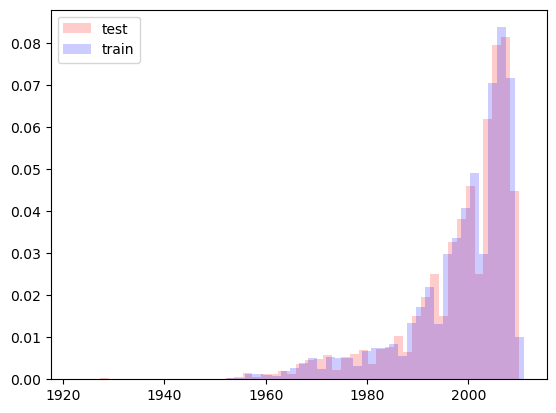

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(Y_test, bins=50, density=True, color='r', alpha=0.2, label='test')
ax.hist(Y_train, bins=50, density=True, color='b', alpha=0.2, label='train')
ax.legend()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class Regressor(nn.Module):
    def __init__(self, infea:int=90, hidden:int=200, out:int=2, *args, **kwargs):
        super(Regressor, self).__init__(*args, **kwargs)
        self.infea = infea
        self.hidden = hidden
        self.out = out
        self.encoder = nn.Sequential(
            nn.Linear(infea, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden*2),
            nn.BatchNorm1d(hidden*2),
            nn.ReLU(),
            nn.Linear(hidden*2, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
            nn.Linear(hidden*4, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
            nn.Linear(hidden*4, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
        )
        self.final = nn.Linear(hidden*4, out)

    def forward(self, x: Tensor):
        h = self.encoder(x)
        logits = self.final(h)
        return logits

In [5]:
def huber(x, k=0.1):
    return torch.where(x.abs() < k, 0.5*x.pow(2), k * (x.abs() - 0.5*k))

def quantile_huber_loss(y_true: np.ndarray, y_pred: torch.Tensor, quantiles: np.ndarray) -> torch.Tensor:
    u = y_true - y_pred
    s = quantiles - (u < torch.Tensor([0])).float()
    return torch.mean(s.abs() * huber(u))

In [6]:
import torch
import torch.nn as nn

class MultiQuantileLoss(nn.Module):
    def __init__(self, quantiles):
        """
        Initializes the loss function for multiple quantiles.
        Args:
            quantiles (list of float): List of quantiles, e.g., [0.1, 0.9]
        """
        super(MultiQuantileLoss, self).__init__()
        self.quantiles = quantiles

    def forward(self, y_pred, y_true):
        """
        Computes the loss for each quantile and sums them.
        Args:
            y_pred (Tensor): Predicted outputs of shape (batch_size, num_quantiles)
            y_true (Tensor): Ground truth values of shape (batch_size, 1)
        Returns:
            Tensor: Combined loss for all quantiles
        """
        assert y_pred.shape[1] == len(self.quantiles), "Number of outputs must match number of quantiles"
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = y_true - y_pred[:, i:i+1]
            loss = torch.maximum((q - 1) * errors, q * errors)
            losses.append(torch.mean(loss))
        return sum(losses) / len(losses)


In [7]:
import copy
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from typing import Any, Optional, OrderedDict, List
from collections import defaultdict

def train(dataset: Optional[dict], model: nn.Module, optimizer: Optional[Any], scheduler: Optional[Any],
          epoch: int=100, batch_size: int=128, device: str='cpu'):
    trainloss = defaultdict(list)
    testloss = defaultdict(list)
    quantiles = [0.1, 0.9]
    # loss_fn = MultiQuantileLoss(quantiles)

    X_train, X_test, y_train, y_test = dataset['train_x'], dataset['test_x'], dataset['train_y'], dataset['test_y']
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epoch):
        print("epoch: " + str(epoch) + '===================================================')
        n_train = X_train.shape[0]
        n_test = X_test.shape[0]
        if epoch == 0:
            print(f'train length: {n_train}, test length: {n_test}')

        I = list(range(0, n_train))
        
        running_loss = 0.0
        running_test_loss = 0.0

        model.train()
        for i_batch in range(n_train // batch_size):
            if i_batch < (n_train // batch_size - 1):
                I_b = I[i_batch * batch_size:(i_batch+1) * batch_size]
            else:
                I_b = I[i_batch * batch_size:]
            x_batch = X_train[I_b, :]
            y_batch = y_train[I_b]

            x_batch = torch.from_numpy(x_batch).to(torch.float32).to(device)
            y_batch = torch.from_numpy(y_batch).to(torch.int64).to(device)
            y_batch = y_batch.unsqueeze(-1)
            # print(y_batch)

            with torch.set_grad_enabled(True):
                logits = model(x_batch)
                # loss = torch.nn.functional.cross_entropy(logits, y_batch)
                # loss = loss_fn(logits, y_batch)
                loss = quantile_huber_loss(y_batch, logits, torch.tensor(quantiles))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                trainloss['loss'].append(loss.item())
                running_loss += loss.item() * x_batch.size(0)

            if i_batch > 0 and i_batch % 50 == 0:
                print(f'ibatch: {i_batch}, train loss: {loss}.')
        
        epoch_loss = running_loss / n_train
        
        trainloss['epoch'].append(epoch_loss)

        I = list(range(0, n_test))
        model.eval()
        for i_batch in range(n_test // batch_size):
            if i_batch < (n_test // batch_size - 1):
                I_b = I[i_batch * batch_size:(i_batch+1) * batch_size]
            else:
                I_b = I[i_batch * batch_size:]
            x_batch = X_test[I_b, :]
            y_batch = y_test[I_b]

            x_batch = torch.from_numpy(x_batch).to(torch.float32).to(device)
            y_batch = torch.from_numpy(y_batch).to(torch.int64).to(device)
            y_batch = y_batch.unsqueeze(-1)

            with torch.set_grad_enabled(False):
                logits = model(x_batch)
                # loss = torch.nn.functional.cross_entropy(logits, y_batch)
                # loss = loss_fn(logits, y_batch)
                loss = quantile_huber_loss(y_batch, logits, torch.tensor(quantiles))

                testloss['loss'].append(loss.item())
                running_test_loss += loss.item()*x_batch.size(0)
                
        epoch_test_loss = running_test_loss / n_test
                
        testloss['epoch'].append(epoch_test_loss)

        print(f'test loss: {epoch_test_loss}.')

    time_elapsed = time.time() - since
    print(("Training complete in %sm %ss" % (time_elapsed // 60, time_elapsed % 60)))

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    #         'scheduler_state_dict': scheduler.state_dict(),
        'trainloss': trainloss,
        'testloss': testloss,
        }, 'model_final')
    return model, trainloss, testloss

In [8]:
device = 'cpu'

datasets = dict()
datasets['train_x'] = X_train
datasets['test_x'] = X_test
datasets['train_y'] = Y_train
datasets['test_y'] = Y_test

model = Regressor().to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

model, trainloss, valloss = train(dataset=datasets, model=model, optimizer=optimizer, 
                                  scheduler=scheduler, epoch=50, batch_size=1024)

epoch: 0===================================================
train length: 463810, test length: 51535
ibatch: 50, train loss: 75.66140747070312.
ibatch: 100, train loss: 6.681036949157715.
ibatch: 150, train loss: 1.6923846006393433.
ibatch: 200, train loss: 1.438183307647705.
ibatch: 250, train loss: 0.5467063784599304.
ibatch: 300, train loss: 0.8949030041694641.
ibatch: 350, train loss: 0.5769916772842407.
ibatch: 400, train loss: 0.7152804732322693.
ibatch: 450, train loss: 0.7253684997558594.
test loss: 1.8167409424940484.
epoch: 1===================================================
ibatch: 50, train loss: 0.6198968291282654.
ibatch: 100, train loss: 0.6683244705200195.
ibatch: 150, train loss: 0.9563542604446411.
ibatch: 200, train loss: 0.5362266898155212.
ibatch: 250, train loss: 0.3749392330646515.
ibatch: 300, train loss: 0.43208104372024536.
ibatch: 350, train loss: 0.544086217880249.
ibatch: 400, train loss: 0.25060755014419556.
ibatch: 450, train loss: 0.6372766494750977.
te

51535


(array([6.0000e+00, 9.1000e+01, 4.0100e+02, 7.0100e+02, 9.8700e+02,
        1.2760e+03, 1.6680e+03, 2.3320e+03, 3.6160e+03, 7.5100e+03,
        1.1238e+04, 9.3430e+03, 4.5970e+03, 2.0560e+03, 1.3920e+03,
        9.9400e+02, 6.7700e+02, 5.2400e+02, 4.1700e+02, 3.4900e+02,
        2.8700e+02, 2.1500e+02, 1.6700e+02, 1.3500e+02, 1.2200e+02,
        8.5000e+01, 7.9000e+01, 6.7000e+01, 4.7000e+01, 3.4000e+01,
        2.3000e+01, 1.8000e+01, 1.9000e+01, 9.0000e+00, 4.0000e+00,
        1.6000e+01, 1.2000e+01, 6.0000e+00, 6.0000e+00, 3.0000e+00,
        1.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-21.54248047, -19.80265808, -18.0628376 , -16.32301521,
        -14.58319378, -12.84337139, -11.10354996,  -9.36372757,
         -7.62390614,  -5.8840847 ,  -4.14426279,  -2.40444088,
         -0.66461915,   1.07520258,   2.81502438,   4.55484629,
          6.2946682 ,   8.03448963,   9.77431107,  11.51413345

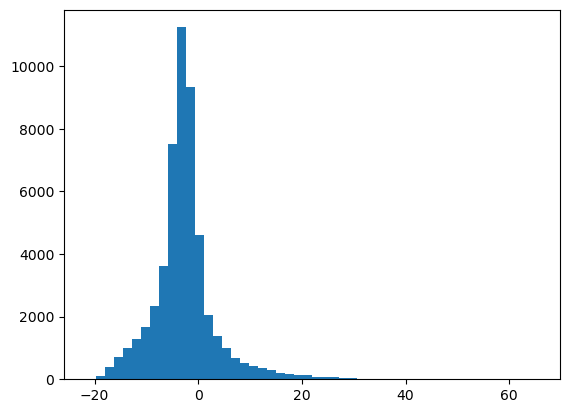

In [9]:
x_test = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test = torch.from_numpy(Y_test).to(torch.int64).to(device)

scores = torch.maximum(model(x_test)[:,0]-y_test, y_test-model(x_test)[:,1])
print(len(scores))
fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(scores.detach().cpu().numpy(), density=False, bins=50)

In [10]:
alpha = 0.1
n = len(scores)
# print(scores)
qhat = torch.quantile(scores, np.ceil((n+1)*(1-alpha))/n)
print(qhat)

tensor(3.4007, grad_fn=<SqueezeBackward4>)


51535


/var/folders/7f/h_yx8r3d3rb_y8lsptbgys440000gn/T/ipykernel_34057/630092371.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores_ = torch.tensor(scores)


avg cov: 0.900296
avg cov: 0.899851


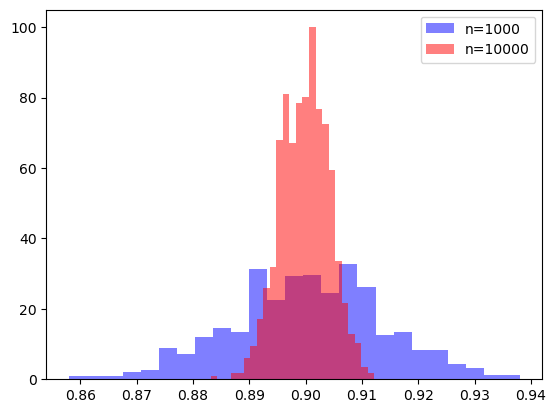

In [11]:
R = 1000
print(n)
alpha=0.1
scores_ = torch.tensor(scores)
coverages = torch.zeros((R,))
for r in range(R):
    scores__ = scores_[torch.randperm(51535)]
    calib_scores, val_scores = (scores__[:1000], scores__[50535:])
    qhat_ = torch.quantile(calib_scores, np.ceil((n+1)*(1-alpha))/n)
    coverages[r] = (val_scores <= qhat_).float().mean()
average_coverage = coverages.mean()
print('avg cov: %f' % average_coverage)

coverages2 = torch.zeros((R,))
for r in range(R):
    scores__ = scores_[torch.randperm(51535)]
    calib_scores, val_scores = (scores__[:10000], scores__[41535:])
    # print(calib_scores.mean())
    qalpha = np.ceil((n+1)*(1-alpha))/n
    # print(qalpha)
    qhat_ = torch.quantile(calib_scores, qalpha)
    # print(qhat_)
    coverages2[r] = (val_scores <= qhat_).float().mean()
average_coverage = coverages2.mean()
print('avg cov: %f' % average_coverage)
plt.hist(coverages,bins=25,density=True,label='n=1000', color='blue', alpha=0.5)
plt.hist(coverages2,bins=25,density=True,label='n=10000', color='red', alpha=0.5)
plt.legend()

torch.Size([463810])
463810


(array([3.0620e+04, 2.2849e+04, 3.1939e+04, 3.7291e+04, 3.3445e+04,
        2.7082e+04, 1.9766e+04, 1.5433e+04, 1.3899e+04, 1.3073e+04,
        1.1811e+04, 1.1076e+04, 1.0085e+04, 9.2950e+03, 8.4850e+03,
        7.7460e+03, 7.3920e+03, 7.0250e+03, 6.8530e+03, 6.9060e+03,
        6.6120e+03, 6.4890e+03, 6.3240e+03, 6.1800e+03, 6.1480e+03,
        5.8620e+03, 5.8820e+03, 5.6620e+03, 5.5050e+03, 5.4020e+03,
        5.0130e+03, 4.8600e+03, 4.7530e+03, 8.2340e+03, 9.3110e+03,
        8.6300e+03, 8.2290e+03, 7.4340e+03, 5.8200e+03, 3.5760e+03,
        2.1730e+03, 1.5340e+03, 8.8800e+02, 5.5100e+02, 2.9600e+02,
        1.8600e+02, 8.3000e+01, 4.7000e+01, 4.4000e+01, 1.1000e+01]),
 array([15.00012207, 15.74293701, 16.48575195, 17.22856689, 17.97138184,
        18.71419678, 19.45701172, 20.19982666, 20.9426416 , 21.68545654,
        22.42827148, 23.17108643, 23.91390137, 24.65671631, 25.39953125,
        26.14234619, 26.88516113, 27.62797607, 28.37079102, 29.11360596,
        29.8564209 , 30.59

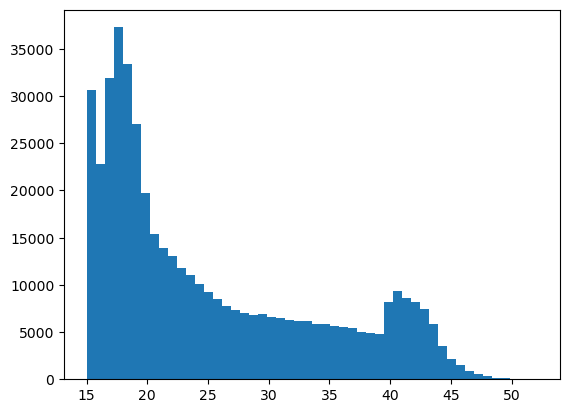

In [12]:
x_train = torch.from_numpy(X_train).to(torch.float32).to(device)

prediction_sets = (model(x_train)[:,0]-qhat, model(x_train)[:,1]+qhat)
print(prediction_sets[0].size())
sets = []
for i in range(x_train.shape[0]):
    sets.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
print(len(sets))
fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(sets, density=False, bins=50)

In [13]:
import os
import sys
sys.path.append(os.getcwd())
import pandas as pd
import numpy as np
from numpy import linalg as LA
import heapq

key_labels = {}
#
def as_string(desc):
    return ' and '.join(desc)

def satisfies_all(desc,df,N):
    d_str = as_string(desc)
    ind = df.eval(d_str)
    cover_desc = sum(ind)
    return (cover_desc / N > 0.0001 and cover_desc / N < 0.5)

class BoundedPriorityQueue:
    """
    Ensures uniqness
    Keeps a maximum size (throws away value with least quality)
    """

    def __init__(self, bound, df):
        self.values = []
        self.bound = bound
        self.entry_count = 0
        self.df = df

    def desc_intersect(self, desc1, coverage, desc2, c):
        ind_new = self.df.eval(as_string(desc1))
        ind_old = self.df.eval(as_string(desc2))
        if coverage*0.9 > c:
            return False
        if (ind_new & ind_old).sum() > c*0.8:
            return True
        return False

    def add(self, element, quality, coverage):
        if any((e == element for (_, _, e, _) in self.values)):
            return  # avoid duplicates

        # if any((self.desc_intersect(element, coverage, e, c) for (_,_,e,c) in self.values)):
        #     return        

        new_entry = (quality, self.entry_count, element, coverage)
        if (len(self.values) >= self.bound):
            temp=heapq.heappushpop(self.values, new_entry)
        else:
            heapq.heappush(self.values, new_entry)

        self.entry_count += 1

    def get_values(self):
        for (q, _, e, coverage) in sorted(self.values, reverse=True):
            yield (e, q, coverage)

    def out_vectors(self):
        return [q for (q, _, _, _) in sorted(self.values, reverse=True)]

    def show_contents(self):  # for debugging
        print("show_contents")
        for (q, entry_count, e, coverage) in self.values:
            # print(q, entry_count, e)
            print("quality: %f, entry: %d, element: %s, coverage: %f" % (q, entry_count, e, coverage))

#
class Queue:
    """
    Ensures uniqness
    """

    def __init__(self):
        self.items = []

    def is_empty(self):
        return self.items == []

    def enqueue(self, item):
        if item not in self.items:
            self.items.insert(0, item)

    def dequeue(self):
        return self.items.pop()

    def size(self):
        return len(self.items)

    def get_values(self):
        return self.items

    def add_all(self, iterable):
        for item in iterable:
            self.enqueue(item)

    def clear(self):
        self.items.clear()

In [18]:
def refine(desc, more):
    copy = desc[:]
    copy.append(more)
    return copy

def eta(seed,fs,df):
    for f in fs:
        column_data = df[f]
        if (df[f].dtype == 'float32'):
            min_val, max_val = min(column_data), max(column_data)
            for x in np.linspace(min_val, max_val, 10):
                candidate = "{} <= {value:.3f}".format(f, value=x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {value:.3f}".format(f, value=x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'object'):
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'int64'):
            min_val, max_val = min(column_data), max(column_data)
            for x in np.linspace(min_val, max_val, 10):
                candidate = "{} <= {}".format(f, np.floor(x))
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {}".format(f, np.floor(x))
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'bool'):
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)                    
        else:
            assert False

def varphi_ent(d,n):
    return np.sqrt(-(d/n)*np.log2(d/n) - ((n-d)/n)*np.log2((n-d)/n))

def eval_quality(desc, model, df, mu_omega):
    d_str = as_string(desc)
    ind = df.eval(d_str)
    df_sd = df.loc[ind]

    x_sd = df_sd.values[:, :-1].astype(np.float32)
    x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)

    prediction_sets = (model(x_sd)[:,0]-qhat, model(x_sd)[:,1]+qhat)
    sets_sd = []
    for i in range(x_sd.shape[0]):
        sets_sd.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
    mu_sd = np.mean(sets_sd)
    quality = mu_omega - mu_sd
    # quality = mu_sd - mu_omega

    coverage = sum(ind) / df.shape[0]
    # ent = varphi_ent(sum(ind), df.shape[0])
    return quality, coverage

def EMM(df, fs, model, w, d, q, eta, satisfies_all, eval_quality):
    """
    w - width of beam
    d - num levels
    q - max results
    eta - a function that receives a description and returns all possible refinements
    satisfies_all - a function that receives a description and verifies wheather it satisfies some requirements as needed
    eval_quality - returns a quality for a given description. This should be comparable to qualities of other descriptions
    catch_all_description - the equivalent of True, or all, as that the whole dataset shall match
    """
    N = df.shape[0]

    x_omega = df.values[:, :-1].astype(np.float32)
    x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)

    prediction_sets = (model(x_omega)[:,0]-qhat, model(x_omega)[:,1]+qhat)
    sets_omega = []
    for i in range(x_omega.shape[0]):
        sets_omega.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
    mu_omega = np.mean(sets_omega)
    print('mu omega: %f' % mu_omega)
                
    resultSet = BoundedPriorityQueue(q,df)
    candidateQueue = Queue()
    candidateQueue.enqueue([])
    for level in range(d):
        print("level : %d" % level)
        beam = BoundedPriorityQueue(w,df)
        for seed in candidateQueue.get_values():
            print("seed : %s" % str(seed))
            for desc in eta(seed, fs, df):
                if satisfies_all(desc,df,N):
                    quality, coverage = eval_quality(desc, model, df, mu_omega)
                    resultSet.add(desc, quality, coverage)
                    beam.add(desc, quality, coverage)
        beam.show_contents()
        #candidateQueue.clear()
        candidateQueue = Queue()
        candidateQueue.add_all(desc for (desc, _, _) in beam.get_values())
    return resultSet

In [19]:
features = ['V1', 'V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18', 'V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','V29','V30','V31','V32','V33','V34','V35','V36']

print("features: %s" % features)

# dff = df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
dff = Train[['V1', 'V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18',
        'V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','V29','V30','V31','V32','V33','V34','V35','V36',
        'V37','V38', 'V39','V40','V41','V42','V43','V44','V45','V46','V47','V48','V49','V50','V51','V52','V53','V54',
        'V55','V56','V57','V58','V59','V60','V61','V62','V63','V64','V65','V66','V67','V68','V69','V70','V71','V72',
        'V73','V74','V75','V76','V77','V78','V79','V80','V81','V82','V83','V84','V85','V86','V87','V88','V89','V90', 'year']]
dff = dff.astype(np.float32)
dff = dff.sample(frac=0.1)

EMM_res = EMM(df=dff, fs=features, model=model, w=20, d=2, q=10, eta=eta, satisfies_all=satisfies_all, eval_quality=eval_quality)

for (desc, quality, coverage) in EMM_res.get_values():
	print("{};{};{}\n".format(desc,quality,coverage))

features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36']
mu omega: 25.106234
level : 0
seed : []
show_contents
quality: 5.175479, entry: 213, element: ['V36 <= -92.470'], coverage: 0.031478
quality: 5.276415, entry: 173, element: ['V28 > 1111.133'], coverage: 0.001229
quality: 5.360322, entry: 212, element: ['V36 <= -408.066'], coverage: 0.000841
quality: 5.562593, entry: 27, element: ['V4 > 80.189'], coverage: 0.001833
quality: 5.296992, entry: 37, element: ['V6 <= -54.714'], coverage: 0.000345
quality: 5.445520, entry: 208, element: ['V35 <= -201.227'], coverage: 0.002652
quality: 5.529752, entry: 114, element: ['V18 > 3765.357'], coverage: 0.003320
quality: 6.028366, entry: 7, element: ['V1 > 54.220'], coverage: 0.002824
quality: 5.892138, entry: 17, element: ['V3 <= -94.950'], coverage: 0

mu omega: 25.106234
['V35 <= -342.419', 'V6 <= -1.723'];10.106161012713482;0.00010780276406287057

5
['V35 <= -342.419', 'V1 > 41.529'];9.671761598650983;0.00010780276406287057

5
['V3 <= -94.950', 'V35 <= -201.227'];9.655402891825325;0.0004096505034389082

19
['V35 <= -201.227', 'V3 <= -94.950'];9.655402891825325;0.0004096505034389082

19
['V29 > 1065.996', 'V22 > 917.670'];9.61805981642442;0.00017248442250059293

8
15605


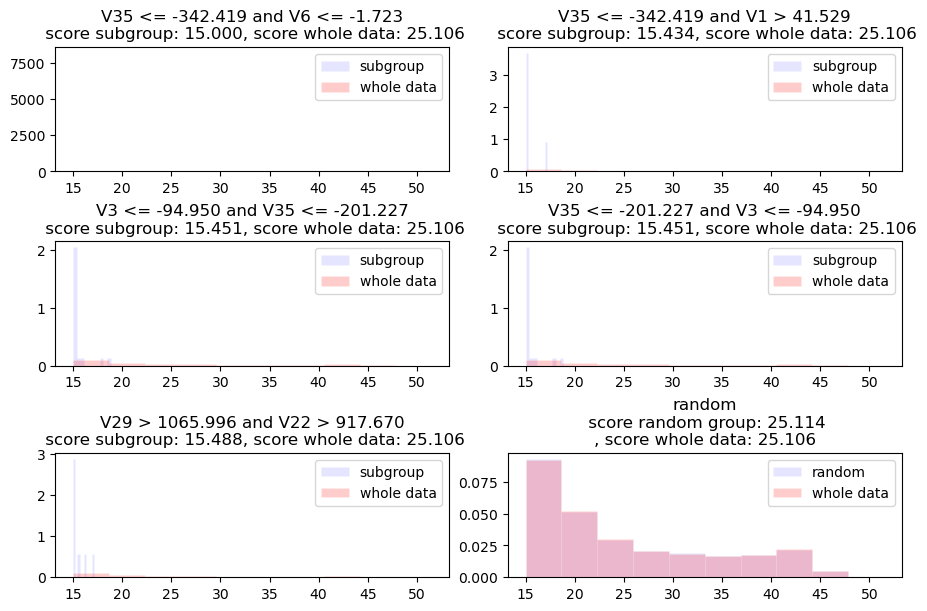

In [21]:
N_dff = dff.shape[0]

x_omega = dff.values[:, :-1].astype(np.float32)
x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)

prediction_sets = (model(x_omega)[:,0]-qhat, model(x_omega)[:,1]+qhat)
sets_omega = []
for i in range(x_omega.shape[0]):
	sets_omega.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
mu_omega = np.mean(sets_omega)
print('mu omega: %f' % mu_omega)

k = 0
q = 5
fig, axs = plt.subplots(3, 2, figsize=(9, 6), layout='constrained')

for (desc, quality, coverage) in EMM_res.get_values():
	print("{};{};{}\n".format(desc, quality, coverage))
	d_str = as_string(desc)
	ind = dff.eval(d_str)
	df_sd = dff.loc[ind]

	x_sd = df_sd.values[:, :-1].astype(np.float32)
	x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)

	prediction_sets = (model(x_sd)[:,0]-qhat, model(x_sd)[:,1]+qhat)
	sets_sd = []
	for i in range(x_sd.shape[0]):
		sets_sd.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
	mu_sd = np.mean(sets_sd)
	print(len(sets_sd))
	quality = mu_omega - mu_sd

	ax = axs.flat[k]
	if ax is None:
		ax = plt.gca()

	preds_sd = sets_sd
	preds_wd = sets_omega
	ax.hist(preds_sd, linewidth=0.5, edgecolor="white", color='b', alpha=0.1, label='subgroup', density=True)
	ax.hist(preds_wd, linewidth=0.5, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
	score_sd = np.mean(sets_sd)
	score_all = np.mean(sets_omega)
	ax.set_title(f'{d_str}\n score subgroup: {(score_sd):<0.3f}, score whole data: {(score_all):<0.3f}')
	ax.legend()
	k += 1
	if k == 5:
		break

inds_rand = np.random.permutation(N_dff)
flag = np.random.randint(np.int32(0.2*N_dff), np.int32(0.5*N_dff))
inds_rand = inds_rand[:flag]
inputs = dff.iloc[inds_rand]

x_rand = inputs.values[:, :-1].astype(np.float32)
x_rand = torch.from_numpy(x_rand).to(torch.float32).to(device)
prediction_sets = (model(x_rand)[:,0]-qhat, model(x_rand)[:,1]+qhat)
sets_rand = []
for i in range(x_rand.shape[0]):
	sets_rand.append(prediction_sets[1][i].item()-prediction_sets[0][i].item())
mu_sd = np.mean(sets_rand)
print(len(sets_rand))

ax = axs.flat[k]
preds_sd = sets_rand
preds_wd = sets_omega
ax.hist(preds_sd, linewidth=0.5, edgecolor="white", color='b', alpha=0.1, label='random', density=True)
ax.hist(preds_wd, linewidth=0.5, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
score_sd = np.mean(sets_rand)
score_all = np.mean(sets_omega)
ax.set_title(f'{'random'}\n score random group: {(score_sd):<0.3f}\n, score whole data: {(score_all):<0.3f}')
ax.legend()